In [4]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta


# 定義爬取股票資料的函數
def fetch_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

#定義資料時間
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.now() - timedelta(days=5*365)).strftime('%Y-%m-%d')

# 取得 輸入 的歷史數據
ticker = input()
data = fetch_stock_data(ticker, start_date, end_date)
print(data.head())

[*********************100%%**********************]  1 of 1 completed

                Open      High       Low     Close  Adj Close  Volume
Date                                                                 
2022-12-13  4.383333  4.432667  4.321667  4.359667   3.914813    7200
2022-12-14  4.355000  4.355000  4.183333  4.222333   3.791492    3000
2022-12-15  3.935000  3.955667  3.870000  3.955667   3.552037   13200
2022-12-16  3.885000  3.902500  3.815000  3.820833   3.430961   14400
2022-12-19  3.713000  3.713000  3.713000  3.713000   3.334131    3600


In [5]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 選擇收盤價
data = data[['Close']]

# 正規化資料
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 定義創建訓練和測試數據集的函數
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

# 創建訓練和測試數據集
time_step = 100
X, Y = create_dataset(scaled_data, time_step)

# 轉換為 PyTorch 張量
import torch

X_train = torch.from_numpy(X).float()
Y_train = torch.from_numpy(Y).float()

In [6]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, output_size=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        out, _ = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM()

In [7]:
import torch.optim as optim

# 定義損失函數和優化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 訓練模型
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train.unsqueeze(2))
    optimizer.zero_grad()
    loss = criterion(outputs, Y_train.unsqueeze(1))
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [0/100], Loss: 0.1278
Epoch [10/100], Loss: 0.0652
Epoch [20/100], Loss: 0.0385
Epoch [30/100], Loss: 0.0355
Epoch [40/100], Loss: 0.0296
Epoch [50/100], Loss: 0.0189
Epoch [60/100], Loss: 0.0066
Epoch [70/100], Loss: 0.0048
Epoch [80/100], Loss: 0.0033
Epoch [90/100], Loss: 0.0025


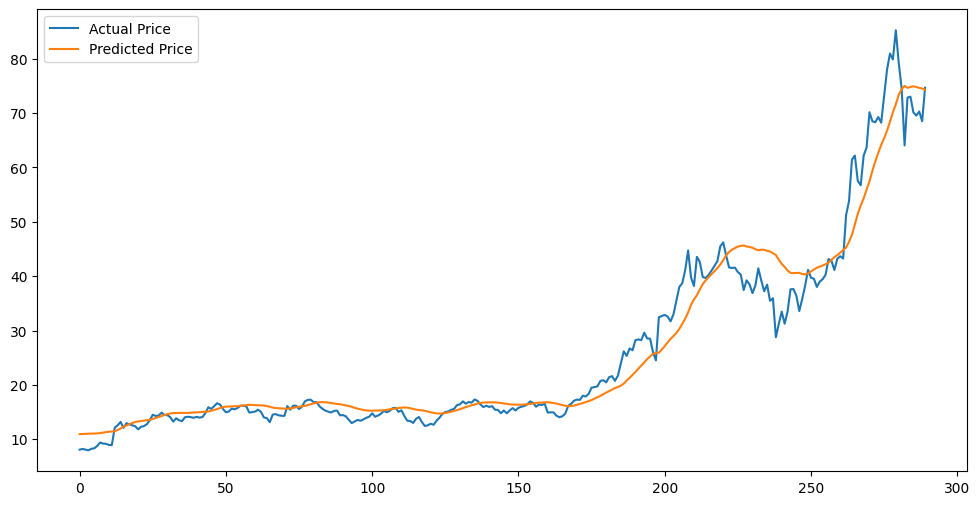

In [8]:
model.eval()
with torch.no_grad():
    train_predict = model(X_train.unsqueeze(2))
train_predict = train_predict.data.numpy()

# 反正規化
train_predict = scaler.inverse_transform(train_predict)
Y_train_actual = scaler.inverse_transform(Y_train.unsqueeze(1).data.numpy())

# 繪製結果
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(Y_train_actual, label='Actual Price')
plt.plot(train_predict, label='Predicted Price')
plt.legend()
plt.show()

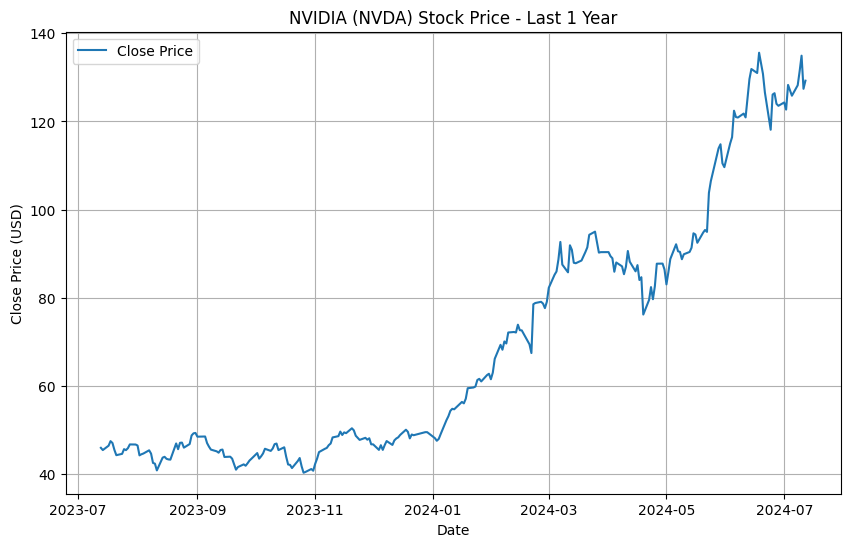

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt

# 下載NVDA的股票數據
nvda = yf.Ticker("NVDA")
nvda_history = nvda.history(period="1y")

# 繪製股票價格圖
plt.figure(figsize=(10, 6))
plt.plot(nvda_history.index, nvda_history['Close'], label='Close Price')
plt.title('NVIDIA (NVDA) Stock Price - Last 1 Year')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()
